# ERA5 wave parameter data

Notebook environment to migrate NetCDF files to CF compliant zarr

In [1]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Import standard packages
import os
import pathlib
import sys

import numpy as np
#import geopandas as gpd
 
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob
import itertools
import json
import copy
from itertools import chain
from shapely import wkb

# Import custom functionality
# sys.path.append('c:/Windows/System32/coclicodata/src')#CLENMAR ADDED

from coclicodata.drive_config import p_drive
from coclicodata.etl.cf_compliancy_checker import check_compliancy, save_compliancy
#P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\01_Hazards\01_Present\Extreme_Wave_Height
# Define (local and) remote drives
# gca_data_dir = pathlib.Path.home().joinpath(r"OneDrive - Stichting Deltares\Documents\GitHub")
gca_data_dir = p_drive.joinpath("11209197-018-global-coastal-atlas", r"MSc_students\ClenmarRowe\Data\All_Datasets", r"Orig_Datasets\01_Hazards\01_Present")

# Workaround to the Windows OS (10) udunits error after installation of cfchecker: https://github.com/SciTools/iris/issues/404
os.environ["UDUNITS2_XML_PATH"] = str(
    pathlib.Path().home().joinpath(  # change to the udunits2.xml file dir in your Python installation
        r"AppData\Local\miniconda3\pkgs\udunits2-2.2.28-h892ecd3_0\Library\share\udunits\udunits2.xml" ###Changed from anaconda to miniconda  - added the new package udunits file
    )
)


<IPython.core.display.Javascript object>

In [3]:
# Project paths & files (manual input)
dataset_dir = gca_data_dir.joinpath("Extreme_Wave_Height")
dataset_dir_path = gca_data_dir.joinpath("Extreme_Wave_Height","era5_coastal_Hs_all_years.nc")
CF_dir = gca_data_dir.joinpath("Extreme_Wave_Height","CF")  # directory to save output CF check files

<IPython.core.display.Javascript object>

In [4]:
ds = xr.open_dataset(dataset_dir_path)
ds

<xarray.Dataset>
Dimensions:    (points: 9662, time: 350640)
Coordinates:
    longitude  (points) float32 ...
    latitude   (points) float32 ...
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
  * points     (points) int64 0 1 2 3 4 5 6 ... 9656 9657 9658 9659 9660 9661
Data variables:
    swh        (time, points) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-02 18:48:31 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

<IPython.core.display.Javascript object>

### Check CF compliancy original NetCDF files

In [5]:
%%capture cap --no-stderr
# check original CF compliancy (for first file)

check_compliancy(testfile=dataset_dir_path, 
                 working_dir=CF_dir
                 )

<IPython.core.display.Javascript object>

In [6]:
# save original CF compliancy (for first file)
save_compliancy(cap, testfile=dataset_dir_path, working_dir=CF_dir)

{'P:\\11209197-018-global-coastal-atlas\\MSc_students\\ClenmarRowe\\Data\\All_Datasets\\Orig_Datasets\\01_Hazards\\01_Present\\Extreme_Wave_Height\\era5_coastal_Hs_all_years.nc': {'warnings': '3', 'errors': '0'}}


<IPython.core.display.Javascript object>

### Make CF compliant alterations to the NetCDF files (dataset dependent)

In [7]:
import json

# NetCDF attribute alterations by means of metadata template
metadata_json=dataset_dir.joinpath("metadata_ERA5_.json")

f_global = open(metadata_json)
meta_global = json.load(f_global)


for attr_name, attr_val in meta_global.items():
    if attr_name == 'PROVIDERS':
        attr_val = json.dumps(attr_val)
    ds.attrs[attr_name] = attr_val

ds.attrs['Conventions'] = "CF-1.8"
ds

<xarray.Dataset>
Dimensions:    (points: 9662, time: 350640)
Coordinates:
    longitude  (points) float32 ...
    latitude   (points) float32 ...
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
  * points     (points) int64 0 1 2 3 4 5 6 ... 9656 9657 9658 9659 9660 9661
Data variables:
    swh        (time, points) float32 ...
Attributes: (12/22)
    Conventions:         CF-1.8
    history:             2019-11-02 18:48:31 GMT by grib_to_netcdf-2.14.0: /o...
    TITLE:               ERA5 Wave Data
    TITLE_ABBREVIATION:  era5wd
    DESCRIPTION:         Wave data from the ECMWF Reanalysis v5 (ERA5) with 1...
    SHORT_DESCRIPTION:   Wave data from the ECMWF Reanalysis v5 (ERA5)
    ...                  ...
    CITATION:            ECMWF. (n.d.). ERA5 Reanalysis. Retrieved February 2...
    DOI:                 https://doi.org/10.23615/e5b46c44-8a4f-4a56-b9b6-7a4...
    LONG_NAME:           ERA5_WAVE_DATA
    UNITS:               Metric
    COMMENT:             ERA5 provides hourly estimates of a large number of ...
    CRS:                 EPSG:4326

<IPython.core.display.Javascript object>

In [8]:
# ds = ds.rename_dims({"points": "nstations"})

# # rename variables, if necessary
# ds = ds.rename_vars(
#       #"country":"stations"}, 
#       {"longitude": "lon", "latitude": "lat","points":"stations"}, 
#   )
# ds

<IPython.core.display.Javascript object>

In [9]:


# # set some data variables to coordinates to avoid duplication of dimensions in later stage
# ds = ds.set_coords(["lon", "lat"])

# ds

<IPython.core.display.Javascript object>

In [10]:

dataset_attributes = {
        # "stations": {"long_name": "stations", "units": "1"}, # set to 1 if no unit
        "points": {"long_name": "points", "units": "1"}, # set to 1 if no unit
}  # specify custom (CF convention) attributes

ds["points"].attrs=dataset_attributes["points"]
ds

<xarray.Dataset>
Dimensions:    (points: 9662, time: 350640)
Coordinates:
    longitude  (points) float32 ...
    latitude   (points) float32 ...
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
  * points     (points) int64 0 1 2 3 4 5 6 ... 9656 9657 9658 9659 9660 9661
Data variables:
    swh        (time, points) float32 ...
Attributes: (12/22)
    Conventions:         CF-1.8
    history:             2019-11-02 18:48:31 GMT by grib_to_netcdf-2.14.0: /o...
    TITLE:               ERA5 Wave Data
    TITLE_ABBREVIATION:  era5wd
    DESCRIPTION:         Wave data from the ECMWF Reanalysis v5 (ERA5) with 1...
    SHORT_DESCRIPTION:   Wave data from the ECMWF Reanalysis v5 (ERA5)
    ...                  ...
    CITATION:            ECMWF. (n.d.). ERA5 Reanalysis. Retrieved February 2...
    DOI:                 https://doi.org/10.23615/e5b46c44-8a4f-4a56-b9b6-7a4...
    LONG_NAME:           ERA5_WAVE_DATA
    UNITS:               Metric
    COMMENT:             ERA5 provides hourly estimates of a large number of ...
    CRS:                 EPSG:4326

<IPython.core.display.Javascript object>

In [11]:
# # add or change certain variable / coordinate attributes
# ### dataset attributes is a dictionary of dictionaries
# dataset_attributes = {
#    # "Horizon": {"long_name": "horizon", "units": "yr"}, # set to 1 if no unit
#     "lon": {"standard_name": "longitude", "long_name": "longitude", "units": "degrees_east"},
#     "lat": {"standard_name": "latitude", "long_name": "latitude", "units": "degrees_north"},
#     "EWL_100": {"standard_name": "Extreme sea level", "long_name": "Extreme sea level", "units": "m"},

# }  # specify custom (CF convention) attributes

#  # add / overwrite attributes
# for k, v in dataset_attributes.items():
#     try:
#         ds[k].attrs = dataset_attributes[k]
#     except:
#         continue
# ds

<IPython.core.display.Javascript object>

# Slice to reduce size of CF checked NetCDF

In [12]:
ds_slice=ds.sel(time=slice('2008-01-01','2018-01-01'))
ds_slice

<xarray.Dataset>
Dimensions:    (points: 9662, time: 87696)
Coordinates:
    longitude  (points) float32 ...
    latitude   (points) float32 ...
  * time       (time) datetime64[ns] 2008-01-01 ... 2018-01-01T23:00:00
  * points     (points) int64 0 1 2 3 4 5 6 ... 9656 9657 9658 9659 9660 9661
Data variables:
    swh        (time, points) float32 ...
Attributes: (12/22)
    Conventions:         CF-1.8
    history:             2019-11-02 18:48:31 GMT by grib_to_netcdf-2.14.0: /o...
    TITLE:               ERA5 Wave Data
    TITLE_ABBREVIATION:  era5wd
    DESCRIPTION:         Wave data from the ECMWF Reanalysis v5 (ERA5) with 1...
    SHORT_DESCRIPTION:   Wave data from the ECMWF Reanalysis v5 (ERA5)
    ...                  ...
    CITATION:            ECMWF. (n.d.). ERA5 Reanalysis. Retrieved February 2...
    DOI:                 https://doi.org/10.23615/e5b46c44-8a4f-4a56-b9b6-7a4...
    LONG_NAME:           ERA5_WAVE_DATA
    UNITS:               Metric
    COMMENT:             ERA5 provides hourly estimates of a large number of ...
    CRS:                 EPSG:4326

<IPython.core.display.Javascript object>

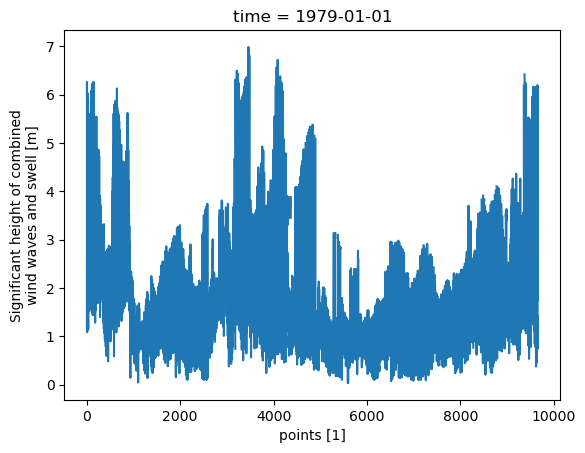

<IPython.core.display.Javascript object>

In [13]:
var=ds['swh'].isel(time=0)
var.plot()
plt.show()

In [14]:
# Write the xarray dataset to a netCDF file
#Compliant netcdf
dataset_dir_path_CF=pathlib.Path().joinpath(str(dataset_dir_path)[0:-3]+"_CF"+".nc")


# ds.to_netcdf(path=dataset_dir_path_CF)
#ds_slice.to_netcdf(path=r"C:\Users\rowe\OneDrive - Stichting Deltares\Desktop\delete\era5_coastal_Hs_all_years_CF.nc")
ds_slice.to_netcdf(path=dataset_dir_path_CF)

<IPython.core.display.Javascript object>

### Check CF compliancy modified NetCDF files

In [15]:
# open datasets (only first file, rest is the same)
ds_slice = xr.open_dataset(dataset_dir_path_CF)

# check original dataset
ds_slice

<xarray.Dataset>
Dimensions:    (points: 9662, time: 87696)
Coordinates:
    longitude  (points) float32 ...
    latitude   (points) float32 ...
  * time       (time) datetime64[ns] 2008-01-01 ... 2018-01-01T23:00:00
  * points     (points) int64 0 1 2 3 4 5 6 ... 9656 9657 9658 9659 9660 9661
Data variables:
    swh        (time, points) float32 ...
Attributes: (12/22)
    Conventions:         CF-1.8
    history:             2019-11-02 18:48:31 GMT by grib_to_netcdf-2.14.0: /o...
    TITLE:               ERA5 Wave Data
    TITLE_ABBREVIATION:  era5wd
    DESCRIPTION:         Wave data from the ECMWF Reanalysis v5 (ERA5) with 1...
    SHORT_DESCRIPTION:   Wave data from the ECMWF Reanalysis v5 (ERA5)
    ...                  ...
    CITATION:            ECMWF. (n.d.). ERA5 Reanalysis. Retrieved February 2...
    DOI:                 https://doi.org/10.23615/e5b46c44-8a4f-4a56-b9b6-7a4...
    LONG_NAME:           ERA5_WAVE_DATA
    UNITS:               Metric
    COMMENT:             ERA5 provides hourly estimates of a large number of ...
    CRS:                 EPSG:4326

<IPython.core.display.Javascript object>

In [16]:
%%capture cap --no-stderr
# check original CF compliancy (for first file)

check_compliancy(testfile=dataset_dir_path_CF, 
                 working_dir=CF_dir
                 )

<IPython.core.display.Javascript object>

In [17]:
# save original CF compliancy (for first file)
save_compliancy(cap, testfile=dataset_dir_path_CF, working_dir=CF_dir)

{'P:\\11209197-018-global-coastal-atlas\\MSc_students\\ClenmarRowe\\Data\\All_Datasets\\Orig_Datasets\\01_Hazards\\01_Present\\Extreme_Wave_Height\\era5_coastal_Hs_all_years_CF.nc': {'warnings': '0', 'errors': '0'}}


<IPython.core.display.Javascript object>

### Write data to Zarr files

In [18]:
# export to zarr in write mode (to overwrite if exists)
ds.to_zarr(str(dataset_dir_path).replace(".nc", ".zarr"), mode="w")

<IPython.core.display.Javascript object>